<a href="https://colab.research.google.com/github/pragyasrivastava0805/congenial-journey/blob/main/Basic_Iterativ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision

from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets

In [ ]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
random_seed=42
torch.manual_seed(random_seed);
val_size = 5000
train_size = len(training_dataset) - val_size
train_ds, val_ds = random_split(training_dataset,[train_size, val_size],generator=torch.manual_seed(random_seed))
len(train_ds), len(val_ds)


(45000, 5000)

In [ ]:
training_loader = torch.utils.data.DataLoader(train_ds, batch_size=100, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(val_ds, batch_size = 100, shuffle=False)

In [ ]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

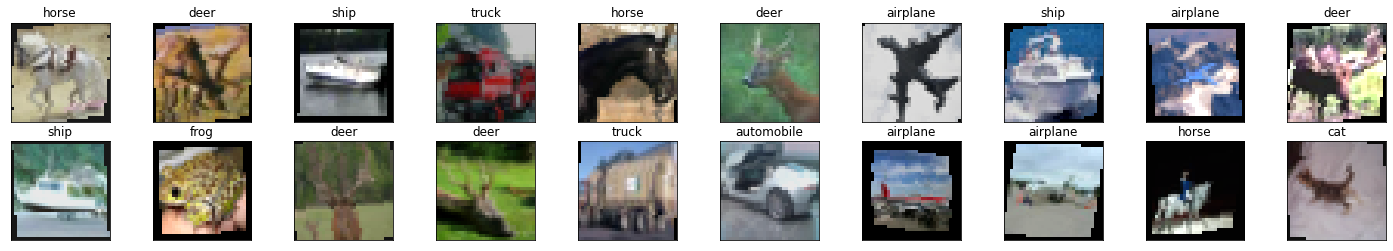

In [ ]:
classes=training_dataset.classes
classes
import numpy as np
dataiter = iter(training_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # input is color image, hence 3 i/p channels. 16 filters, kernal size is tuned to 3 to avoid overfitting, stride is 1 , padding is 1 extract all edge features.
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) # We double the feature maps for every conv layer as in pratice it is really good.
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500) # I/p image size is 32*32, after 3 MaxPooling layers it reduces to 4*4 and 64 because our last conv layer has 64 outputs. Output nodes is 500
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10) # output nodes are 10 because our dataset have 10 different categories
    def forward(self, x):
      x = F.relu(self.conv1(x)) #Apply relu to each output of conv layer.
      x = F.max_pool2d(x, 2, 2) # Max pooling layer with kernal of 2 and stride of 2
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64) # flatten our images to 1D to input it to the fully connected layers
      x = F.relu(self.fc1(x))
      x = self.dropout1(x) # Applying dropout b/t layers which exchange highest parameters. This is a good practice
      x = self.fc2(x)
      return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LeNet().to(device) # run our model on cuda GPU for faster results
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # fine tuned the lr

In [ ]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device) # input to device as our model is running in mentioned device.
    labels = labels.to(device)
    outputs = model(inputs) # every batch of 100 images are put as an input.
    loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 
    
    optimizer.zero_grad() #setting the initial gradient to 0
    loss.backward() # backpropagating the loss
    optimizer.step() # updating the weights and bias values for every single step.
    
    _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

  else:
    with torch.no_grad(): # we do not need gradient for validation.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(training_loader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.7164, acc 37.1467 
validation loss: 1.5440, validation acc 43.9800 
epoch : 2
training loss: 1.4082, acc 49.1867 
validation loss: 1.3470, validation acc 51.7600 
epoch : 3
training loss: 1.2760, acc 54.0933 
validation loss: 1.2182, validation acc 55.9800 
epoch : 4
training loss: 1.1884, acc 58.0089 
validation loss: 1.1788, validation acc 58.2600 
epoch : 5
training loss: 1.1172, acc 60.4867 
validation loss: 1.1306, validation acc 60.0600 
epoch : 6
training loss: 1.0651, acc 62.4267 
validation loss: 1.0843, validation acc 62.1000 
epoch : 7
training loss: 1.0253, acc 63.9089 
validation loss: 1.0297, validation acc 62.7400 
epoch : 8
training loss: 0.9919, acc 65.3267 
validation loss: 1.0162, validation acc 63.7800 
epoch : 9
training loss: 0.9709, acc 65.9289 
validation loss: 0.9562, validation acc 66.5000 
epoch : 10
training loss: 0.9440, acc 67.0800 
validation loss: 0.9691, validation acc 65.6600 
epoch : 11
training loss: 0.9246, acc 67.5622 
va

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle=False)
batch_size=100
with torch.no_grad():
  n_correct=0
  n_samples=0
  n_class_correct=[0 for i in range(10)]
  n_class_samples=[0 for i in range(10)]
  for (images,labels) in test_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs=model(images)
    _,predicted=torch.max(outputs,1)
    n_samples+=labels.size(0)
    n_correct+=(labels==predicted).sum().item()
 
  acc=100.0*n_correct/n_samples
  print(f'accuracy',acc)

accuracy 73.61


In [ ]:
from torch.autograd import Variable
alpha=1
eps=4
def fgsm(x, y, eps):
      x=x.to(device)
      y=y.to(device)
      clamp_max=255
      iters=int(min(1.25*eps,eps+4))
      eps = eps / 255
      clamp_max = clamp_max / 255
      for i in range(iters):
        x.requires_grad=True
        output=model(x)
        model.zero_grad()
        cost=criterion(output,y)
        cost.backward()
        attack_images = x + alpha*x.grad.sign()
        a = torch.clamp(x - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > x+eps).float()*(x+eps) + (x+eps >= b).float()*b
        # d = min{255, c}
        x = torch.clamp(c, max=clamp_max).detach_()
      return x    


In [ ]:
def test( model, device, test_loader, epsilon ):
  correct=0
  tot=len(test_loader)
  for (data, target) in test_loader:

        # Send the data and label to the device
    data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

        # Forward pass the data through the model
    output = model(data)
    _,init_pred = torch.max(output,1) # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
  
    loss = F.nll_loss(output, target)

        # Zero all existing gradients
   
    model.zero_grad()
    loss.backward()

        # Collect datagrad
    data_grad = data.grad.data
    
    p_img=fgsm(data,target,eps)
    output=model(p_img)
    _,f_p=torch.max(output,1)
    correct += (f_p.data.cpu() == target.data.cpu()).sum()
        
  final_acc = correct/float(len(test_dataset))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_dataset), final_acc))
  return final_acc




In [ ]:
accuracies = []
epsilons=np.arange(0,20,2)

# Run test for each epsilon
for eps in epsilons:
    acc = test(model, device, test_loader, eps)
    accuracies.append(acc)
    

Epsilon: 0	Test Accuracy = 7370 / 10000 = 0.7369999885559082
Epsilon: 2	Test Accuracy = 5943 / 10000 = 0.5942999720573425
Epsilon: 4	Test Accuracy = 1759 / 10000 = 0.17589999735355377
Epsilon: 6	Test Accuracy = 342 / 10000 = 0.03420000150799751
Epsilon: 8	Test Accuracy = 37 / 10000 = 0.003700000001117587
Epsilon: 10	Test Accuracy = 4 / 10000 = 0.00039999998989515007
Epsilon: 12	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 14	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 16	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 18	Test Accuracy = 0 / 10000 = 0.0


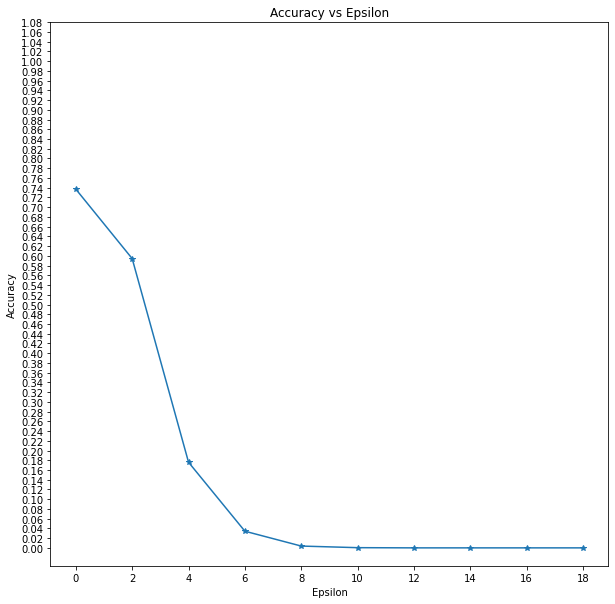

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.02))
plt.xticks(np.arange(0, 20, step=2))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()